# Analysis of Nanocamp Science Identity Construct

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

import re

from sklearn.decomposition import PCA

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

# Read in compiled surveys from both camps

In [3]:
gearup = pd.read_excel('Data/GEAR UP Nanocamp Survey.xlsx')
gearup.set_index('Student ID', inplace=True)

conted = pd.read_excel('Data/Cont Ed Nanocamp Survey.xlsx')
conted.set_index('Student ID', inplace=True)

# Parse results into numerical values.
Each camp is save as a dictionary, with the question as keys and the results for both pre and post sruveys as a multidimensional array.

In [4]:
answer_map = {'strongly disagree': 1, 'disagree': 2, 'neither agree nor disagree': 3, 'neither': 3,
              'agree': 4, 'strongly agree': 5, np.nan: 0}

DATA = []
for df in [gearup, conted]:
    questions = df.columns
    data = {re.findall(r'\[.*?\]', q)[0]: [] for q in questions if 'A [' in q}
    N = len(data)

    for i, q in enumerate(questions):
        if 'A [' in q or 'B [' in q:
            question = list(data.keys())[i % N]
            answers = np.array([answer_map[str(x).lower()] if x is not np.nan else answer_map[np.nan]
                                for x in df.iloc[:, i] ])
            data[question].append(answers)
    DATA.append(data)

# Visualize Results

Show distribution of answers to questions

In [5]:
def filter_out_nans(data_dict, i):
    q = list(data_dict.keys())[i]
    data = np.array(data_dict[q])

    nan_indices = np.where(data == 0)
    cols = np.flip(np.sort(np.array(nan_indices).T[:, 1]))
    for col in cols:
        data = np.delete(data, col, axis=1)
    return data, q

In [24]:
def plot_by_question(data_dict, mode='line', camp='gear_up'):
    categories = ['Competence', 'Performance', 'Recognition']
    ncols = 5
    N = len(data_dict)
    if N % ncols == 0:
        nrows = N // ncols
    else:
        nrows = N // ncols + 1
    fig, axes = plt.subplots(figsize=(ncols * 4, 4.2 * nrows), ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    
    if camp == 'gearup':
        colors = [plt.cm.tab20b(17), plt.cm.tab20b(16), plt.cm.tab20b(19)]
    else:
        colors = [plt.cm.tab20b(13), plt.cm.tab20b(12), plt.cm.tab20b(15)]

    for i in range(int(ncols * nrows)):
        row, colm = np.unravel_index(i, (nrows, ncols))
        if i >= N:
            axes[row, colm].axis('off')
        else:
            data, q = filter_out_nans(data_dict, i)

            if mode == 'line':
                axes[row, colm].plot(data, c=colors[0], alpha=0.25, linewidth=4)
                dx = 0
                axes[row, colm].set_xlim(dx + -0.2, dx + 1.2)
            else:
                axes[row, colm].boxplot(data, patch_artist=True,
                                        medianprops=dict(color=colors[1], linewidth=3),
                                        boxprops=dict(facecolor=colors[2]))
                dx = 1
                axes[row, colm].set_xlim(dx + -0.4, dx + 1.4)

            question = q.replace('[', '').replace(']', '')
            if ',' in question:
                question = question.replace(', ', ',\n')
            elif len(question) > 30:
                split = question.split(' ')
                n = len(split)
                question = ' '.join(split[:n // 2 + 1]) + '\n' + ' '.join(split[n // 2 + 1:])

            axes[row, colm].set_yticks(np.arange(6))
            axes[row, colm].set_xticks([dx + 0, dx + 1])
            axes[row, colm].set_xticklabels(['Before', 'After'])
            axes[row, colm].set_ylim(0.8, 5.2)
            axes[row, colm].tick_params(width=2, length=6, labelsize=16)
            axes[row, colm].set_ylabel(question, fontsize=14)
            if colm == 0:
                 axes[row, colm].text(-0.35, 0.5, categories[row], transform=axes[row, colm].transAxes,
                                      fontweight='bold', fontsize=20, va='center', ha='right',
                                      rotation=90)
                

    plt.savefig(f'Figures/before_vs_after_{mode}_{camp}.png', dpi=400, bbox_inches='tight')

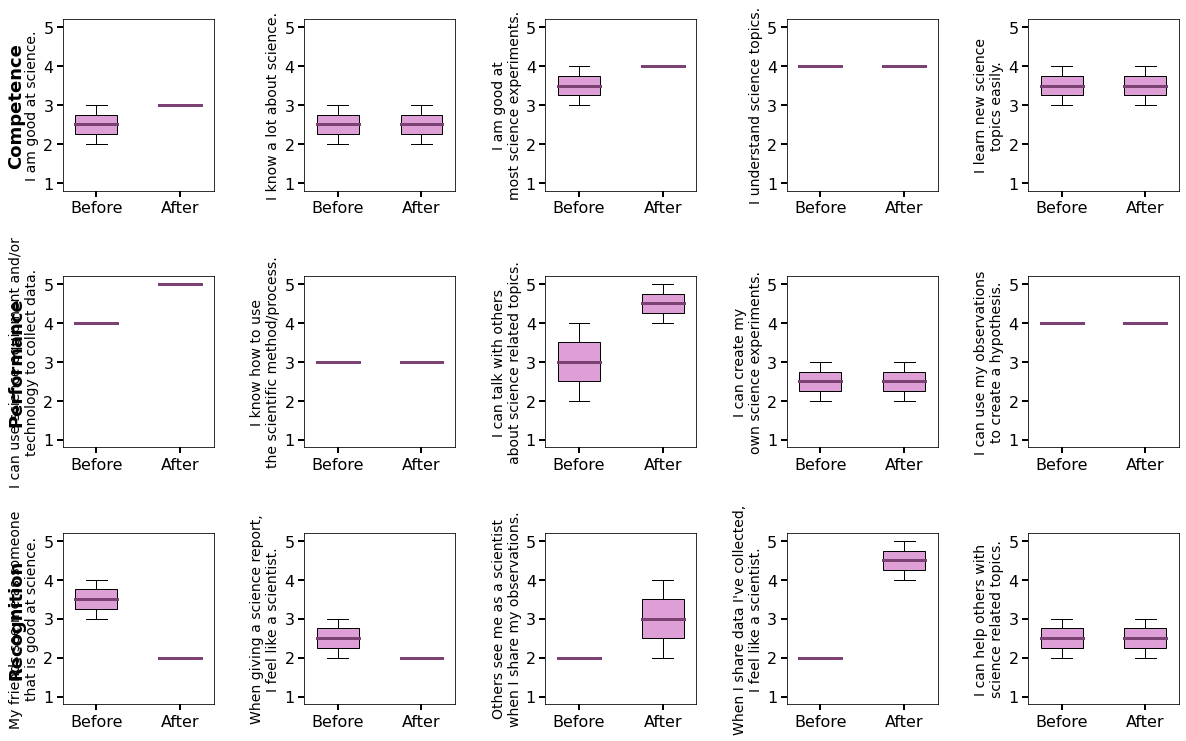

In [25]:
for k, camp in enumerate(['gearup', 'conted']):
    plot_by_question(DATA[k], mode='boxplot', camp=camp)
    #plot_by_question(DATA[k], mode='line', camp=camp)
    break

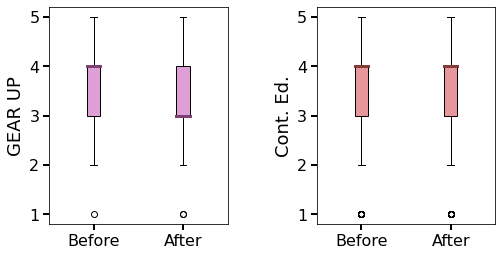

In [27]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.subplots_adjust(wspace=0.5)
colors = [[plt.cm.tab20b(16), plt.cm.tab20b(19)],
          [plt.cm.tab20b(12), plt.cm.tab20b(15)]]

for i, camp in enumerate(['GEAR UP', 'Cont. Ed.']):

    data = np.array(list(DATA[i].values())).reshape(2, -1)
    nan_indices = np.where(data == 0)
    cols = np.flip(np.sort(np.array(nan_indices).T[:, 1]))
    for col in cols:
        data = np.delete(data, col, axis=1)

    axes[i].boxplot(data.T, patch_artist=True,
                    medianprops=dict(color=colors[i][0], linewidth=3),
                    boxprops=dict(facecolor=colors[i][1]))
    
    axes[i].set_ylabel(camp, fontsize=18)
    axes[i].set_yticks(np.arange(6))
    axes[i].set_xticks([1, 2])
    axes[i].set_xticklabels(['Before', 'After'])
    axes[i].set_ylim(0.8, 5.2)
    axes[i].tick_params(width=2, length=6, labelsize=16)
plt.savefig(f'Figures/combined_boxplot.png', dpi=400, bbox_inches='tight')

## Scree plot

In [28]:
def make_scree_plot(plot, data, n=5, threshold=0.95, marker='s',
                    c=plt.cm.tab20b(17), label=None):
    fig, ax = plot
    pca = PCA()
    pca_components = pca.fit_transform(data)

    n_components = 0
    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    for i, val in enumerate(cdf):
        if val > threshold:
            print(f"It takes {i + 1} PCs to explain {int(threshold*100)}% variance.")
            n_components = i + 1
            break

    ax.plot(x, cdf, linestyle='-', marker=marker, markersize=12, fillstyle='none',
            color=c, linewidth=3, label=label)
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

    xticks = np.arange(n) + 1
    
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)
    if label is not None:
        ax.legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')
    
    return n_components

It takes 9 PCs to explain 95% variance.
It takes 9 PCs to explain 95% variance.
It takes 11 PCs to explain 95% variance.
It takes 10 PCs to explain 95% variance.


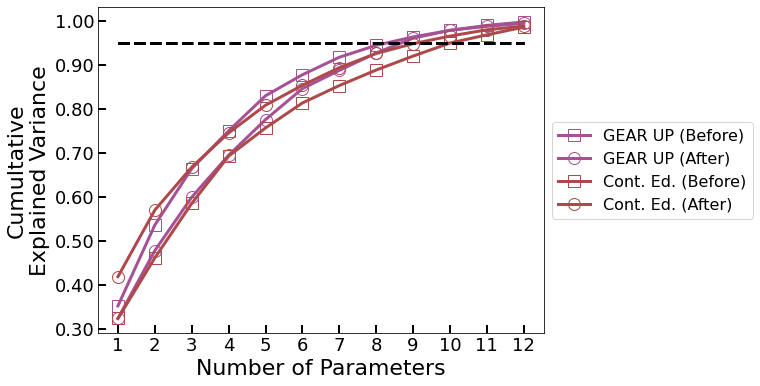

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
colors = [plt.cm.tab20b(17), plt.cm.tab20b(13)]
markers = ['s', 'o']
for i, camp in enumerate(['GEAR UP', 'Cont. Ed.']):
    for j, l in enumerate(['Before', 'After']):
        make_scree_plot((fig, ax), np.array(list(DATA[i].values()))[:, j, :],
                        n=12, threshold=0.95, c=colors[i], label=f'{camp} ({l})',
                        marker=markers[j])

## Visualize change by student

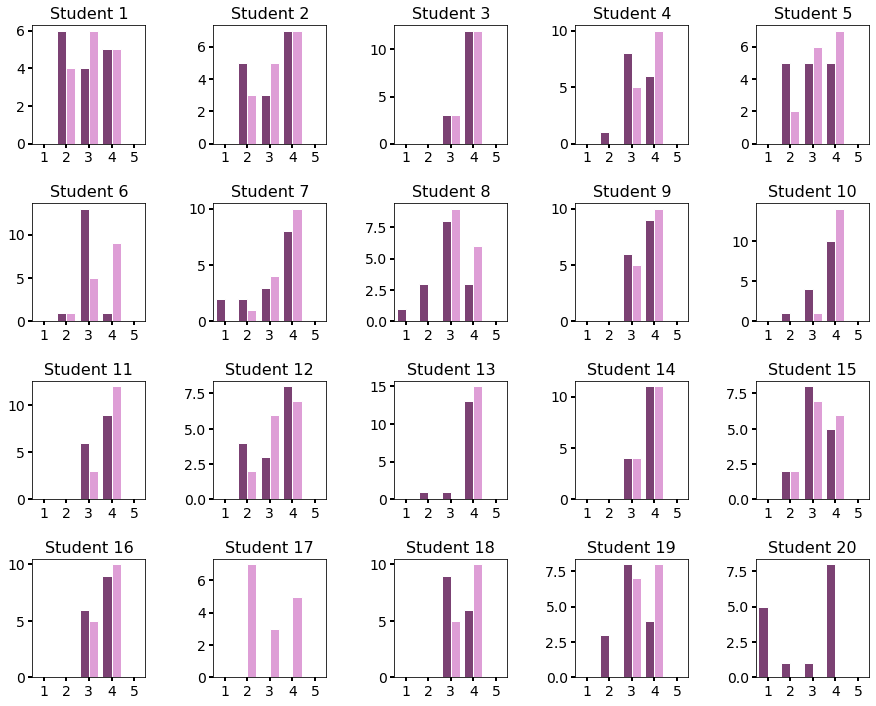

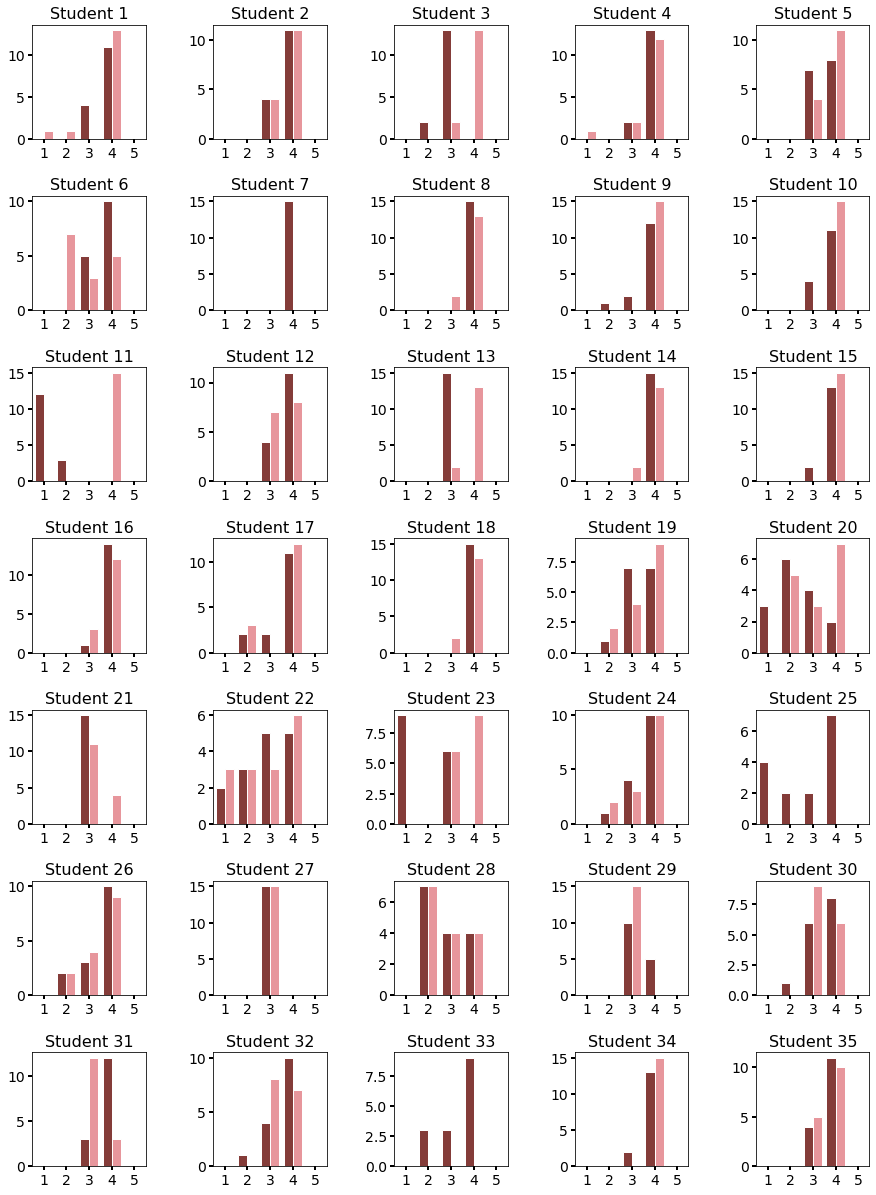

In [33]:
colors = [[plt.cm.tab20b(16), plt.cm.tab20b(19)],
          [plt.cm.tab20b(12), plt.cm.tab20b(15)]]

for i, camp in enumerate(['GEAR UP', 'Cont. Ed.']):
    data = np.array(list(DATA[i].values())).T
    before = data[:, 0, :]
    after = data[:, 1, :]
    n_students = data.shape[0]
    
    ncols = 5
    if n_students % ncols == 0:
        nrows = n_students // ncols
    else:
        nrows = n_students // ncols + 1
    fig, axes = plt.subplots(figsize=(ncols * 3, 3 * nrows), ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    
    for student in range(int(ncols * nrows)):
        row, colm = np.unravel_index(student, (nrows, ncols))
        if student >= n_students:
            axes[row, colm].axis('off')
        else:
            pre = before[student]
            post = after[student]
            bins = np.arange(1, 6)
            axes[row, colm].hist([pre, post], bins=bins, edgecolor='w', color=colors[i])
            axes[row, colm].set_xlim(1, 6)
            axes[row, colm].set_xticks(bins + 0.5, bins)
            axes[row, colm].set_title(f'Student {student + 1}', fontsize=16)
            axes[row, colm].tick_params(width=2, length=4, labelsize=14)
    
    if camp == 'GEAR UP':
        plt.savefig(f'Figures/hist_by_student_gearup.png', dpi=400, bbox_inches='tight')
    elif camp == 'Cont. Ed.':
        plt.savefig(f'Figures/hist_by_student_conted.png', dpi=400, bbox_inches='tight')